In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import logging
from pathlib import Path

import arviz as az
import numpyro

from hb_mep.config import HBMepConfig
from hb_mep.data_access import DataClass
from hb_mep.models.rats.rectified_logistic import RectifiedLogistic
from hb_mep.models.rats.saturated_relu import SaturatedReLU
from hb_mep.models.rats.mixture_model import MixtureModel
from hb_mep.models.rats.utils import load_data

numpyro.set_platform("cpu")
numpyro.set_host_device_count(12)
numpyro.enable_x64()

PARENT_PATH = Path(os.getcwd()).parent.parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

#### Load config

In [3]:
config = HBMepConfig()
config.CURRENT_PATH = PARENT_PATH

#### Load data and preprocess

In [4]:
data = DataClass(config)

a, b = 1, 4
subset = range(a, b)

df, mat, time = load_data(subset, data)
df, encoder_dict = data.build(df)


/home/vishu/repos/hb-mep/data/rats_data/amap01/*/*auc_table.csv
/home/vishu/repos/hb-mep/data/rats_data/amap02/*/*auc_table.csv


2023-05-27 17:06:00,412 - hb_mep.utils.utils - INFO - func:load_data took: 0.35 sec
2023-05-27 17:06:00,413 - hb_mep.data_access.core - INFO - Processing data ...
2023-05-27 17:06:00,420 - hb_mep.utils.utils - INFO - func:preprocess took: 0.01 sec
2023-05-27 17:06:00,420 - hb_mep.utils.utils - INFO - func:build took: 0.01 sec


/home/vishu/repos/hb-mep/data/rats_data/amap03/*/*auc_table.csv


### Rectified Logistic

#### Initialize model

In [5]:
model_rectified_logistic = RectifiedLogistic(config)

#### Run MCMC inference

In [6]:
mcmc_rectified_logistic, posterior_samples_rectified_logistic = \
    model_rectified_logistic.run_inference(df=df)

2023-05-27 17:06:00,588 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
2023-05-27 17:06:00,588 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-27 17:06:00,588 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-27 17:06:00,589 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
2023-05-27 17:06:00,589 - jax._src.xla_bridge - INFO - Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
2023-05-27 17:06:00,626 - hb_mep.models.rats.rectified_logistic - INFO - Running inference with Rec

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-05-27 17:12:30,694 - hb_mep.utils.utils - INFO - func:run_inference took: 6 min and 30.11 sec


#### Diagnostics

In [7]:
mcmc_rectified_logistic.print_summary(prob=.95)


                           mean       std    median      2.5%     97.5%     n_eff     r_hat
             a[0,0,0]    124.14      2.68    124.41    118.83    129.14   9437.70      1.00
             a[0,0,1]     45.53      1.37     45.72     42.65     47.76  10205.62      1.00
             a[0,0,2]     39.77      3.45     40.50     33.00     44.31   5043.43      1.00
             a[0,1,0]    128.70      2.00    128.87    124.79    132.24   9868.30      1.00
             a[0,1,1]    114.39      4.62    114.96    104.98    122.32  10139.16      1.00
             a[0,1,2]    110.56      3.42    110.72    103.00    116.25   6426.62      1.00
             a[0,2,0]    207.94      2.72    207.93    202.56    213.72  12773.38      1.00
             a[0,2,1]    227.34      1.98    227.85    223.01    229.99   5840.35      1.00
             a[0,2,2]    168.97      4.38    169.70    159.19    176.24   4942.68      1.00
             a[0,3,0]    207.10      3.20    207.25    200.58    213.68  11274.

#### Plot fitted curves

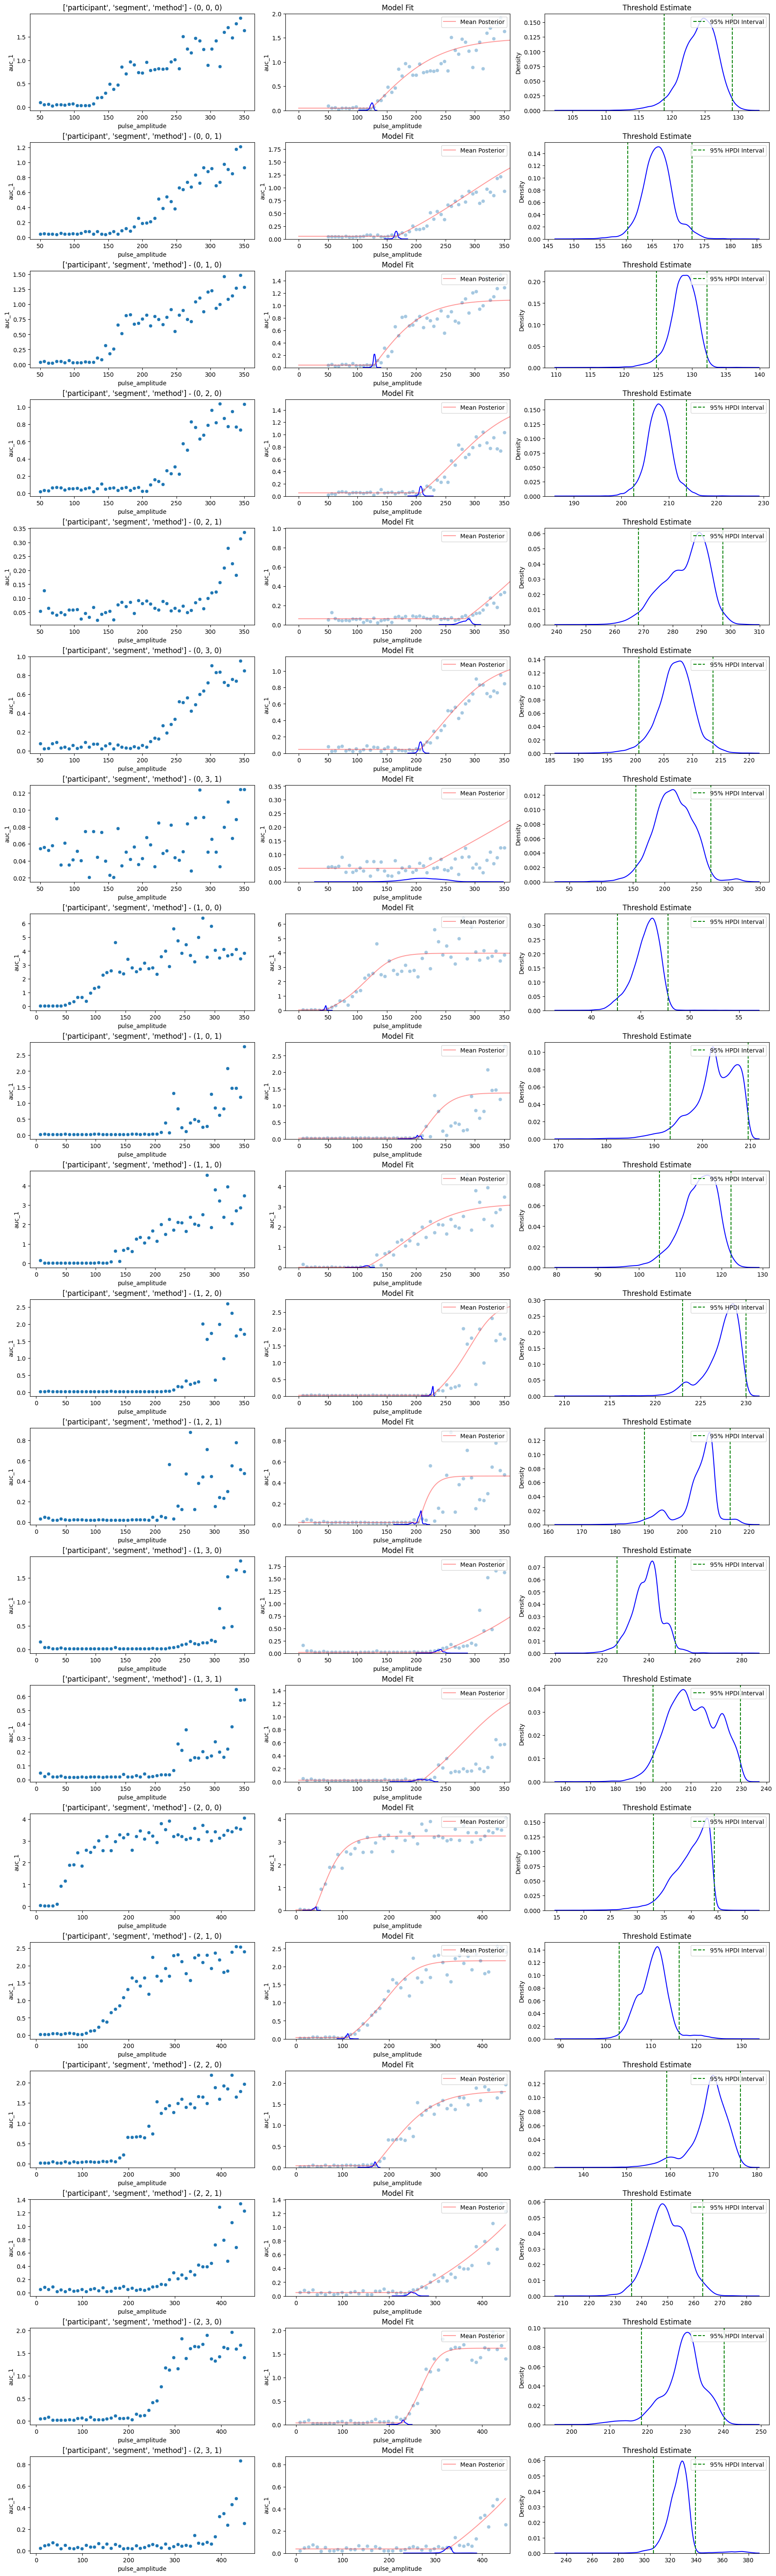

In [8]:
model_rectified_logistic.plot(df=df, posterior_samples=posterior_samples_rectified_logistic);

#### Information Criterion

In [9]:
numpyro_data_rectified_logistic = az.from_numpyro(mcmc_rectified_logistic)

##### Loo

In [10]:
az.loo(numpyro_data_rectified_logistic)


/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 24000 posterior samples and 1007 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  1279.57    55.98
p_loo      147.39        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      960   95.3%
 (0.5, 0.7]   (ok)         18    1.8%
   (0.7, 1]   (bad)        21    2.1%
   (1, Inf)   (very bad)    8    0.8%

##### WAIC

In [11]:
az.waic(numpyro_data_rectified_logistic)

/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 24000 posterior samples and 1007 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  1296.58    54.50
p_waic      130.39        -

There has been a warning during the calculation. Please check the results.

### Saturated Linear

#### Initialize model

In [12]:
model_saturated_relu = SaturatedReLU(config)

#### Run MCMC inference

In [13]:
mcmc_saturated_relu, posterior_samples_saturated_relu = model_saturated_relu.run_inference(df=df)

2023-05-27 17:12:54,275 - hb_mep.models.rats.saturated_relu - INFO - Running inference with Saturated_ReLU ...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-05-27 17:20:50,424 - hb_mep.utils.utils - INFO - func:run_inference took: 7 min and 56.15 sec


#### Diagnostics

In [14]:
mcmc_saturated_relu.print_summary(prob=.95)


                           mean       std    median      2.5%     97.5%     n_eff     r_hat
             a[0,0,0]    121.27      4.33    122.01    112.02    128.52   2639.11      1.00
             a[0,0,1]     46.61      1.18     46.81     44.11     48.34   6353.42      1.00
             a[0,0,2]     38.93      4.64     40.08     29.36     44.51   3600.99      1.00
             a[0,1,0]    128.57      2.15    128.75    124.36    132.40   7287.42      1.00
             a[0,1,1]    114.88      3.43    115.10    108.00    121.12  12927.73      1.00
             a[0,1,2]    112.91      3.25    112.66    106.51    121.22   4687.72      1.00
             a[0,2,0]    208.02      2.58    208.03    202.82    213.48  11237.35      1.00
             a[0,2,1]    228.05      1.73    228.53    224.14    230.37   5074.11      1.00
             a[0,2,2]    167.67      4.61    168.67    157.66    175.25   4834.80      1.00
             a[0,3,0]    206.33      2.95    206.54    200.04    211.69   5706.

#### Plot fitted curves

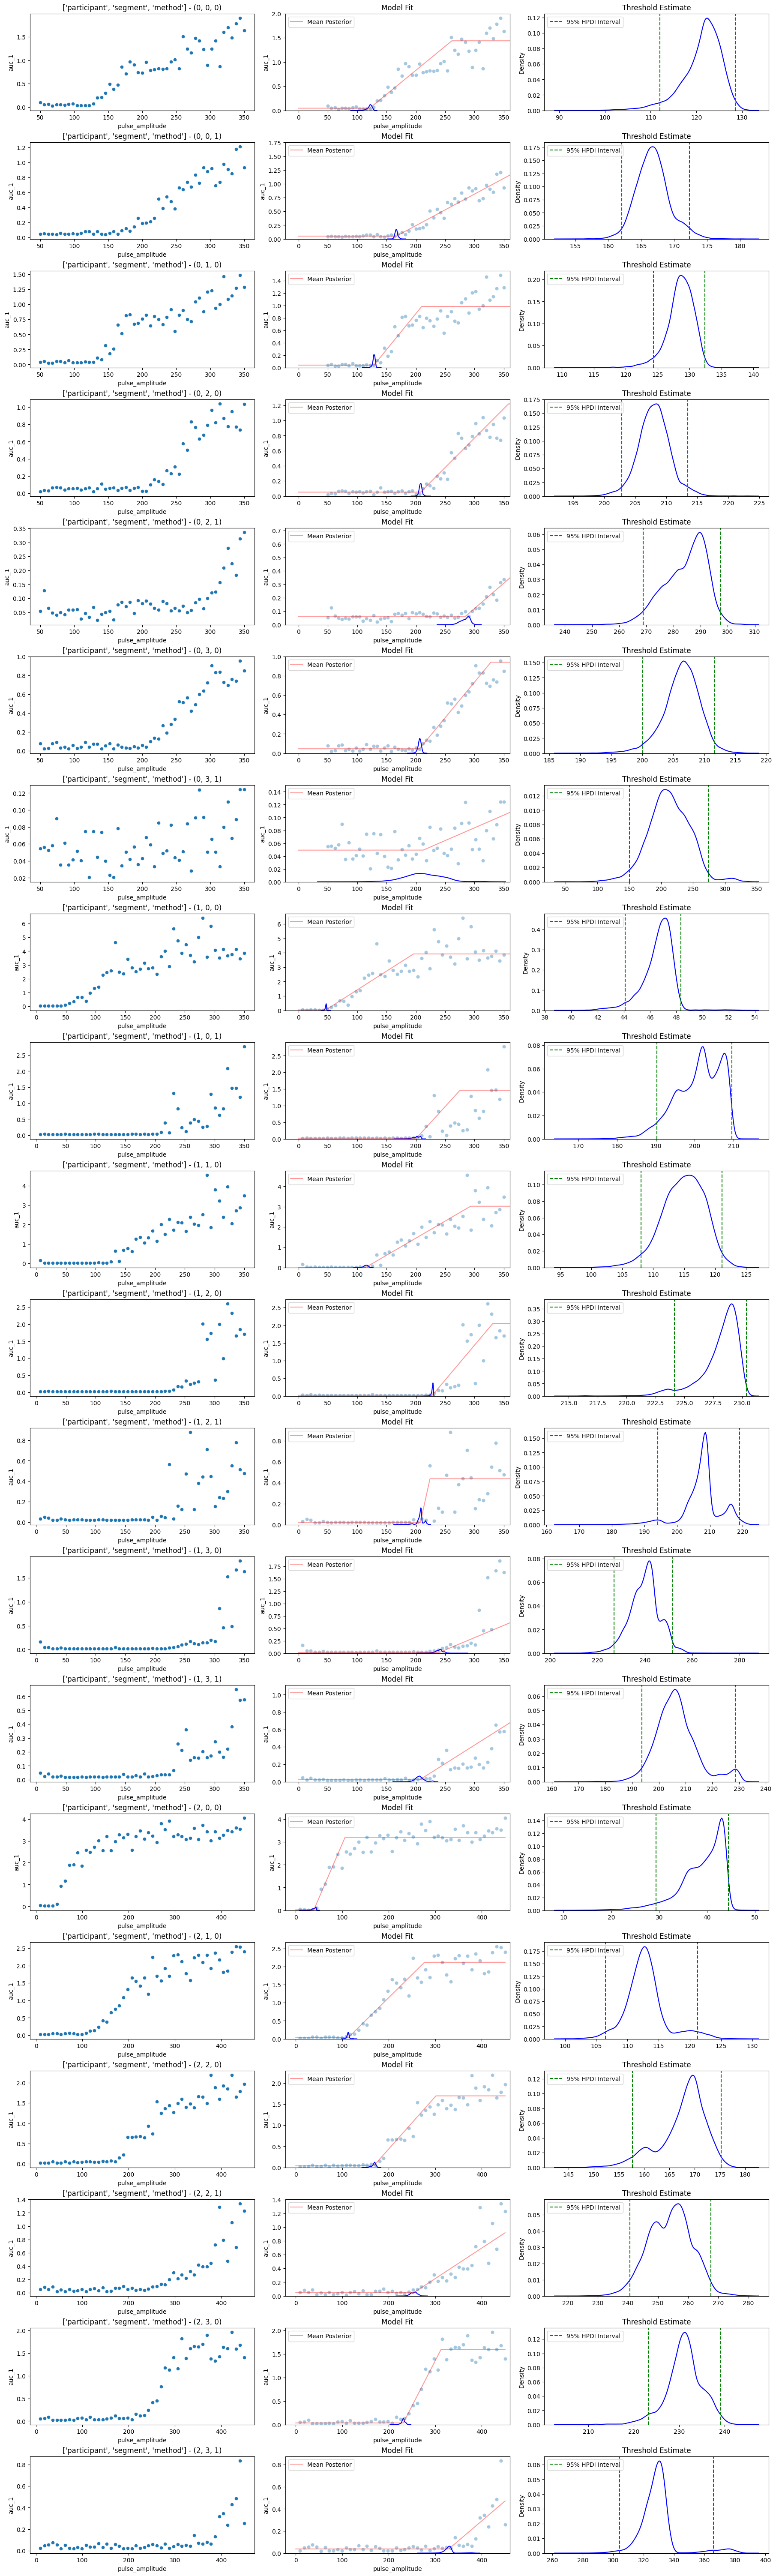

In [15]:
model_saturated_relu.plot(df=df, posterior_samples=posterior_samples_saturated_relu);

#### Information Criterion

In [16]:
numpyro_data_saturated_relu = az.from_numpyro(mcmc_saturated_relu)

##### Loo

In [17]:
az.loo(numpyro_data_saturated_relu)

/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 24000 posterior samples and 1007 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  1241.84    56.87
p_loo      154.77        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      956   94.9%
 (0.5, 0.7]   (ok)         24    2.4%
   (0.7, 1]   (bad)        17    1.7%
   (1, Inf)   (very bad)   10    1.0%

##### WAIC

In [18]:
az.waic(numpyro_data_saturated_relu)

/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 24000 posterior samples and 1007 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  1257.30    55.79
p_waic      139.30        -

There has been a warning during the calculation. Please check the results.

### Mixture Model

#### Initialize model

In [19]:
model_mixture = MixtureModel(config)

#### Run MCMC inference

In [20]:
mcmc_mixture, posterior_samples_mixture = model_mixture.run_inference(df=df)

2023-05-27 17:21:11,185 - hb_mep.models.rats.mixture_model - INFO - Running inference with Mixture_Model ...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-05-27 17:30:50,188 - hb_mep.utils.utils - INFO - func:run_inference took: 9 min and 39.00 sec


#### Diagnostics

In [21]:
mcmc_mixture.print_summary(prob=.95)


                           mean       std    median      2.5%     97.5%     n_eff     r_hat
             a[0,0,0]    124.01      2.67    124.30    118.60    128.90  11789.04      1.00
             a[0,0,1]     45.60      1.35     45.78     42.73     47.82  11705.39      1.00
             a[0,0,2]     33.14      4.82     34.96     24.27     41.00   4296.80      1.00
             a[0,1,0]    128.53      2.32    128.63    123.38    132.67  12305.21      1.00
             a[0,1,1]    121.78      1.70    121.94    118.79    124.24   3128.40      1.00
             a[0,1,2]    112.90      4.87    112.20    104.58    122.24   5374.38      1.00
             a[0,2,0]    207.68      3.11    207.61    201.06    213.31   6657.36      1.00
             a[0,2,1]    227.07      2.43    227.55    222.17    230.04   1451.05      1.00
             a[0,2,2]    168.04      5.48    169.46    156.19    176.21   5472.39      1.00
             a[0,3,0]    207.14      3.28    207.26    200.66    214.23  14793.

#### Plot fitted curves

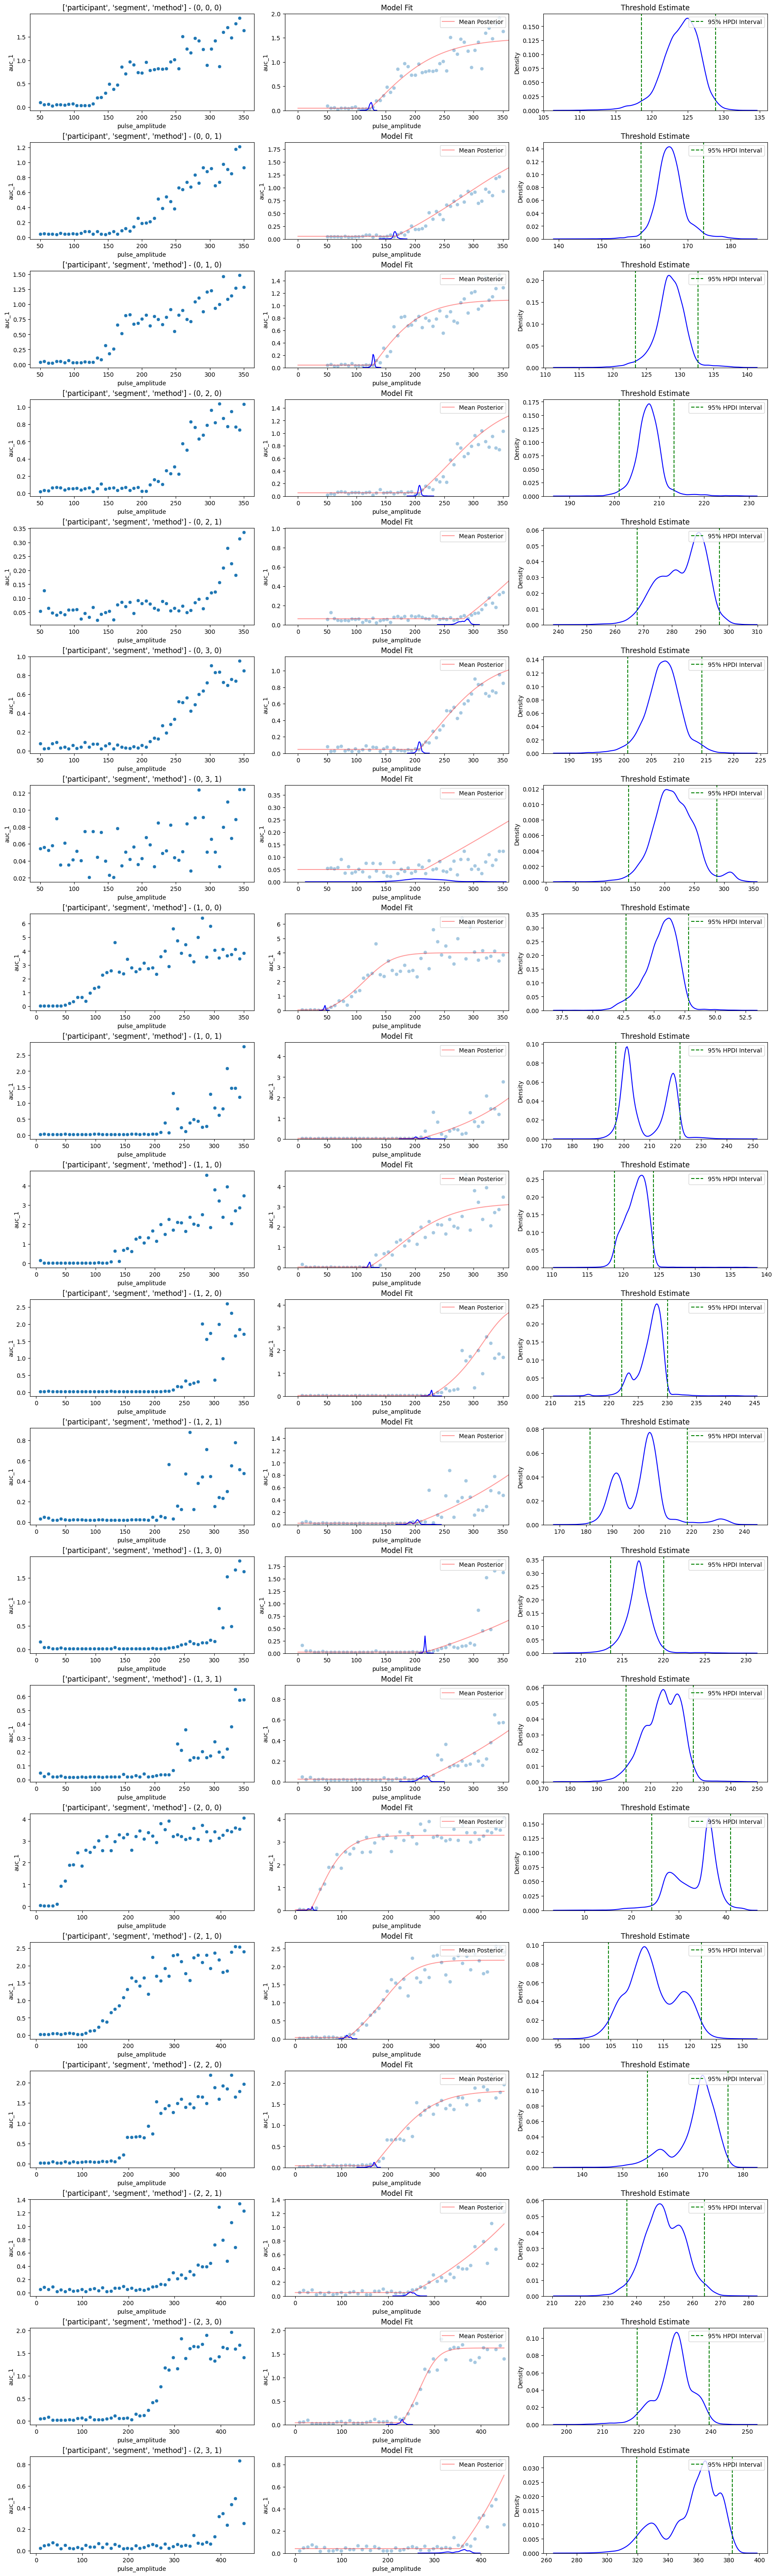

In [22]:
model_mixture.plot(df=df, posterior_samples=posterior_samples_mixture);

#### Information Criterion

In [23]:
numpyro_data_mixture = az.from_numpyro(mcmc_mixture)

##### Loo

In [24]:
az.loo(numpyro_data_mixture)

/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 24000 posterior samples and 1007 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  1296.50    59.56
p_loo      153.32        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      937   93.0%
 (0.5, 0.7]   (ok)         23    2.3%
   (0.7, 1]   (bad)        36    3.6%
   (1, Inf)   (very bad)   11    1.1%

##### WAIC

In [25]:
az.waic(numpyro_data_mixture)

/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 24000 posterior samples and 1007 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  1303.42    59.56
p_waic      146.40        -

There has been a warning during the calculation. Please check the results.

### Model Comparison

In [26]:
az.compare({
    "Rectified_Logistic": numpyro_data_rectified_logistic,
    "Saturated_ReLU": numpyro_data_saturated_relu,
    "Mixture_Model": numpyro_data_mixture
})

/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pare

rank     elpd_loo       p_loo  elpd_diff        weight  \
Mixture_Model          0  1296.502850  153.315941   0.000000  5.566513e-01   
Rectified_Logistic     1  1279.570775  147.391814  16.932075  4.433487e-01   
Saturated_ReLU         2  1241.838844  154.766854  54.664006  5.575540e-13   

                           se        dse  warning scale  
Mixture_Model       59.564580   0.000000     True   log  
Rectified_Logistic  55.980860  25.149902     True   log  
Saturated_ReLU      56.869722  25.457694     True   log